# Demo of functionalities in QAOA Utilities

This notebooks walks through some of the key features provided by `utilities.py`. The methods therein fall into four categories:

* Methods for creating Hamiltonians and graphs, and converting between the two.
* Methods for converting input datasets to QAOA problem instances, which may be used to solve clustering using MaxCut.
* Methods allowing parameter sweeps to be performed, with a view to studying the landscape of the optimisation problem being tackled.
* Functions that illustrate some known analytical and empirical results from literature on QAOA.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Type, Iterable

# import the neccesary pyquil modules
from pyquil.api import WavefunctionSimulator
from pyquil.paulis import PauliSum, PauliTerm

# import QAOAParameters classes 
from entropica_qaoa.qaoa.parameters import StandardParams, AbstractParams, ExtendedParams, QAOAParameterIterator

# import optimiser, cost functions, and utilities
from entropica_qaoa.vqe.optimizer import scipy_optimizer
from entropica_qaoa.qaoa.cost_function import QAOACostFunctionOnQVM, QAOACostFunctionOnWFSim
from entropica_qaoa.utilities import *

## Hamiltonians and graphs

In QAOA, a problem instance is defined by its corresponding *hyperparameters*, which refers to a specification of the total number of qubits `nqubits`, and one or both of the following:

1. The single qubits that have a bias term (denoted `singles`) and the corresponding bias coefficients (denoted `biases`).
2. The pairs of qubits that are coupled (denoted `pairs`), and the corresponding coupling coefficients (denoted `couplings`).

Equivalently, when viewed as a network graph problem, a QAOA instance is defined by specifying the total number of vertices or nodes in the graph, and one or both of the following: 

1. The vertices that have a bias term, and the corresponding bias coefficients.
2. The pairs of vertices that are connected by an edge, and the corresponding edge weight.

If we have a known set of problem hyperparameters, the `hamiltonian_from_hyperparams` allows us to easily create the corresponding Hamiltonian. 

In [2]:
nqubits = 3
singles = [1]
biases = [0.3]
pairs = [[0,1], [1,2]]
couplings = [0.4, 0.6]

h0 = hamiltonian_from_hyperparams(nqubits,singles,biases,pairs,couplings)
print(h0)

(0.4+0j)*Z0*Z1 + (0.6+0j)*Z1*Z2 + (0.3+0j)*Z1


The `random_hamiltonian` method generates a random Hamiltonian (problem instance) for a specified number of qubits. It randomly selects a number of biases and number of couplings, then assigns each of them a random value between zero and one. For instance, let's create two 4-qubit Hamiltonians.

In [3]:
h1 = random_hamiltonian(4)
h2 = random_hamiltonian(4)
print("h1 =",h1)
print()
print("h2 =",h2)

h1 = (0.4107963981420346+0j)*Z1 + (0.616913488978027+0j)*Z0 + (0.26657390069515885+0j)*Z3 + (0.21157597688789542+0j)*Z0*Z1 + (0.12170068236774811+0j)*Z1*Z3 + (0.21585891069066987+0j)*Z2*Z3

h2 = (0.14326439957787607+0j)*Z0 + (0.3225071997293999+0j)*Z2 + (0.6965791188903577+0j)*Z0*Z1 + (0.9942379534872605+0j)*Z0*Z3 + (0.025280812683850518+0j)*Z1*Z3 + (0.5230952158849098+0j)*Z2*Z3


We can create a `networkx` graph corresponding to the qubit couplings in `h1 `using the `graph_from_hamiltonian` method:

/usr/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:563: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/usr/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:569: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
/usr/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  for c in edge_color]):
/usr/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: 
The is_numlike function was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use isinstance(..., numbers.Number) instead.
  if cb.is_numlike(alpha):


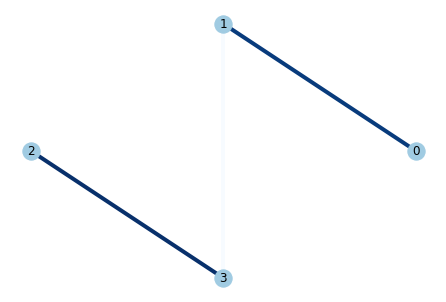

In [4]:
g1 = graph_from_hamiltonian(h1)
plot_graph(g1)

We can alternatively work backwards, creating a graph first, then the corresponding Hamiltonian using the `hamiltonian_from_graph` method. 

Let's take the graph we have just produced (`g1`) and convert it back to its corresponding Hamiltonian, which we called `h1` above.

In [5]:
H1 = hamiltonian_from_graph(g1)
print('From graph:', H1)
print('Original:', h1)

From graph: (0.616913488978027+0j)*Z0 + (0.4107963981420346+0j)*Z1 + (0.26657390069515885+0j)*Z3 + (0.21157597688789542+0j)*Z0*Z1 + (0.12170068236774811+0j)*Z1*Z3 + (0.21585891069066987+0j)*Z2*Z3
Original: (0.4107963981420346+0j)*Z1 + (0.616913488978027+0j)*Z0 + (0.26657390069515885+0j)*Z3 + (0.21157597688789542+0j)*Z0*Z1 + (0.12170068236774811+0j)*Z1*Z3 + (0.21585891069066987+0j)*Z2*Z3


We can also create a graph directly from hyperparameters, using the `graph_from_hyperparams` method. 

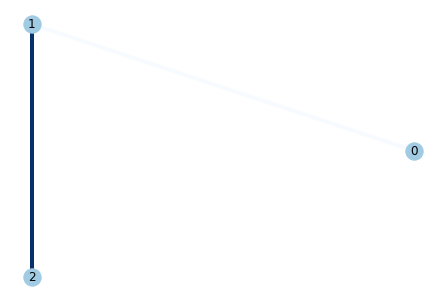

In [6]:
g0 = graph_from_hyperparams(nqubits,singles,biases,pairs,couplings)
plot_graph(g0)

## Hamiltonians and data

One prominent application of QAOA is to solve the weighted MaxCut problem, which may be used as a clustering technique - see, for example, https://arxiv.org/abs/1712.05771.

The pairwise distance between a given pair of data points in a dataset is used as the weight on the corresponding graph, and enters the Hamiltonian as the corresponding coupling coefficient between the corresponding qubits.

## Simple toy datasets for QAOA MaxCut clustering

Here we demo some of the methods for generating simple datasets for QAOA clustering problems. Let's create a data set of two clusters, where the points in each cluster follow Gaussian statistics.

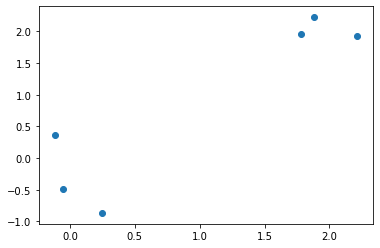

In [7]:
n_clusters = 2 # Number of clusters we want
n_points = [3,3] # Number of points in each cluster
means = [[0,0], [2,2]] # Cluster means (the [x,y] coordinates of each cluster)

# Covariance matrix: we will use the same one for each of the two clusters here
# but more generally they could be different
cov_matrix = [[0.1, 0], [0, 0.1]] 
cov_matrices = [cov_matrix,cov_matrix]

myData1 = gaussian_2Dclusters(n_clusters,n_points,means,cov_matrices)
plot_cluster_data(myData1)

Now let's set up the MaxCut problem. We compute the distances using `distances_dataset`, which returns a `dict` whose keys are the data point pairs, and whose values are the Euclidean distances between them

In [8]:
dists = distances_dataset(myData1)
dists

array([[0.        , 0.86588484, 0.47641398, 3.3190582 , 3.33471949,
        3.06301123],
       [0.86588484, 0.        , 1.28850653, 2.80435687, 2.72412956,
        2.47553616],
       [0.47641398, 1.28850653, 0.        , 3.42358508, 3.49871128,
        3.21895954],
       [3.3190582 , 2.80435687, 3.42358508, 0.        , 0.4438514 ,
        0.4320019 ],
       [3.33471949, 2.72412956, 3.49871128, 0.4438514 , 0.        ,
        0.28254445],
       [3.06301123, 2.47553616, 3.21895954, 0.4320019 , 0.28254445,
        0.        ]])

In [9]:
hData = hamiltonian_from_distance_matrix(dists)
print(hData)

(0.8658848417366792+0j)*Z0*Z1 + (0.4764139831062393+0j)*Z0*Z2 + (3.3190582033038476+0j)*Z0*Z3 + (3.3347194858001226+0j)*Z0*Z4 + (3.0630112259818554+0j)*Z0*Z5 + (1.288506533157254+0j)*Z1*Z2 + (2.804356871873529+0j)*Z1*Z3 + (2.7241295579731357+0j)*Z1*Z4 + (2.4755361593189473+0j)*Z1*Z5 + (3.4235850790864437+0j)*Z2*Z3 + (3.4987112811187697+0j)*Z2*Z4 + (3.218959541498697+0j)*Z2*Z5 + (0.4438514041103187+0j)*Z3*Z4 + (0.4320019011182804+0j)*Z3*Z5 + (0.28254445225684927+0j)*Z4*Z5


Now that we have the Hamiltonian, we can go ahead and run the QAOA to check that the points are clustered correctly. We will use the `ExtendedParams` class, and three timesteps (p=3). We don't include any single-qubit bias terms.

In [10]:
n_qubits = 6
p = 3

# Specify some angles
betas = np.random.rand(n_qubits,p)
gammas_singles = []
gammas_pairs = np.random.rand(len(hData),p)
parameters = (betas,gammas_singles,gammas_pairs)

extended_params = ExtendedParams([hData,p],parameters)
print(extended_params)

Hyperparameters:
	register: [0, 1, 2, 3, 4, 5]
	qubits_singles: []
	qubits_pairs: [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
Parameters:
	betas: [[0.40539102 0.59172827 0.6627732  0.68020347 0.36396819 0.83715333], [0.36517214 0.00394934 0.11983505 0.8019383  0.00832927 0.13157907], [0.3304932  0.17057377 0.66373771 0.44036153 0.24868883 0.70467367]]
	gammas_singles: []
	gammas_pairs: [[0.17239556 0.60351712 0.06741244 0.21210715 0.04450264 0.9940744,  0.69024799 0.00112186 0.87666917 0.95249181 0.86341477 0.03900441,  0.92225533 0.00735683 0.73402723], [0.29103021 0.2150731  0.74601044 0.50066098 0.58788796 0.19256803,  0.04821098 0.20678955 0.2891335  0.99547793 0.68257085 0.17173571,  0.09089894 0.26521406 0.95417465], [0.18025725 0.33315405 0.59933734 0.0873386  0.45561748 0.09606644,  0.02039187 0.5750169  0.06072861 0.51177675 0.90021621 0.15388562,  0.79963297 0.28388944 0.00628278]]



In [11]:
# NOTE - the optimiser will reach its maximum number of iterations, but for the parameters being used here,
# the choice maxiter=200 seems to be more than sufficient to get to the optimum with high probability.

sim = WavefunctionSimulator() # Define the wavefunction simulator
cost_function = QAOACostFunctionOnWFSim(hData,
                                        params=extended_params,
                                        sim=sim,
                                        scalar_cost_function=False,
                                        nshots=1,
                                        noisy=False)

res = scipy_optimizer(cost_function, extended_params.raw(), epsilon=1e-3,
                      maxiter=200)
res

     fun: -13.755224258717837
   maxcv: 0.0
 message: 'Maximum number of function evaluations has been exceeded.'
    nfev: 200
  status: 2
 success: False
       x: array([ 4.03584355e-01,  1.58899038e+00,  7.87181427e-01,  6.79758529e-01,
        3.64453908e-01,  1.83680340e+00,  3.64852877e-01,  8.72787363e-01,
        1.01342275e+00,  8.04538790e-01,  7.98961691e-03,  6.86507808e-02,
        4.39193452e-01,  7.52742197e-02,  7.39994993e-01,  4.41712024e-01,
        2.04077040e-01,  6.89437501e-01,  1.65340984e-01,  5.93911363e-01,
        1.08340192e+00,  2.15953370e-01,  1.04128820e+00,  1.00565117e+00,
        1.69229747e+00,  1.59441169e-03,  8.76645130e-01,  9.50575815e-01,
        8.52790907e-01,  3.45639422e-02,  9.86563912e-01,  1.09411249e-01,
        1.60664478e+00,  3.00584973e-01,  2.10440396e-01,  7.41787719e-01,
        1.52557010e+00,  1.59072040e+00,  1.62083286e-01, -4.33805878e-02,
        2.04978402e-01,  3.05752950e-01,  1.03550831e+00,  6.74225408e-01,
        1

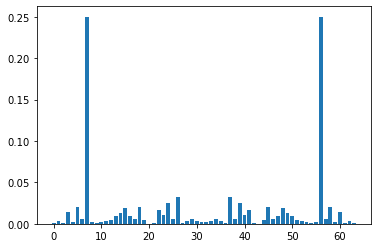

In [12]:
opt_wfn = cost_function.get_wavefunction(res.x)
probs = opt_wfn.probabilities()
plt.bar(range(len(probs)),probs)
plt.show()

Now get the string corresponding to the optimal solution. The `argmax` function will return the first of the two degenerate solutions. As expected, we find that the first three qubits are in one class, and the second three qubits in another (this is the way the data was constructed).

In [13]:
optimal_string = np.argmax(probs)
"{0:06b}".format(optimal_string)

'000111'

We can check that the other optimal solution found is the complement bitstring, i.e. 111000:

In [18]:
probs[optimal_string] = 0 # Sets the previously found optimal solution to have zero probability
optimal_string_complement = np.argmax(probs)
"{0:06b}".format(optimal_string_complement)

'111000'

## Landscape sweeps 
This section shows how to use the `QAOAParameterIterator` class, which allows one to compute the cost function value of parametric wavefunctions produced by QAOA circuits, where one or two parameters of interest are varied, and all others are kept fixed. Let's work again with a simple 2-qubit problem, in the `ExtendedParams` class, with $p=3$ timesteps.

In [19]:
h_test = []
h_test.append(PauliTerm("Z", 0, 0.7)*PauliTerm("Z", 1))
h_test.append(PauliTerm("Z", 0, -0.5))
h_test = PauliSum(h_test)

We require 3x2 `betas` parameters, 3x1 `gammas_singles` and 3x1 `gammas_pairs` parameters, which we will initialise randomly:

In [20]:
betas = np.random.rand(3,2)
gammas_singles = np.random.rand(3,1)
gammas_pairs = np.random.rand(3,1)
parameters = (betas,gammas_singles,gammas_pairs)

In [21]:
extendedparams = ExtendedParams([h_test,3],parameters)
print(extendedparams)

Hyperparameters:
	register: [0, 1]
	qubits_singles: [0]
	qubits_pairs: [[0, 1]]
Parameters:
	betas: [[0.1971542  0.30779525], [0.99218142 0.26973451], [0.20081884 0.86410033]]
	gammas_singles: [[0.08838537], [0.7086255 ], [0.94220576]]
	gammas_pairs: [[0.1131439 ], [0.96079268], [0.11370092]]



We have a total of 12 parameters; as an example, let's focus on how the cost function value changes when we vary the `beta` angle on the second qubit in the second QAOA step (p=2). This is the `[1][1]` in the `betas` list. We will vary its range from 0 to $2\pi$.

In [22]:
range_ = np.linspace(0,2*np.pi,100)
param_ = "betas[1][1]"
iterator = QAOAParameterIterator(extendedparams, param_, range_)

We now want to compute the cost function value with all the different values of the specified parameter of interest.

In [23]:
sim = WavefunctionSimulator() # Define the wavefunction simulator

cost_vals = np.zeros((len(range_,)))
dev_vals = np.zeros((len(range_,)))
ind = 0
for i,p in zip(range(len(range_)),iterator):
    
    cost_function = QAOACostFunctionOnWFSim(h_test,
                                            params=p,
                                            sim=sim,
                                            scalar_cost_function=False,
                                            nshots = 1000,
                                            noisy=False)
    
    
    val,dev = cost_function(p.raw(),nshots=1000)
    cost_vals[i] = val
    dev_vals[i] = dev

Below we plot the energy landscape as a function of the parameter of interest in the specified range, together with the standard deviation. A more thorough set of methods for visualising energy landscapes will be demonstrated in a separate notebook.

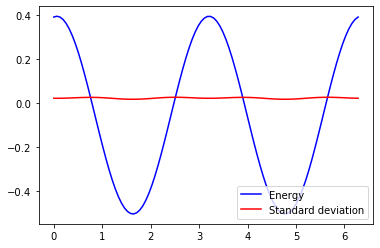

In [24]:
plt.plot(range_,cost_vals,'b',range_,dev_vals,'r')
plt.legend(('Energy', 'Standard deviation'),
           loc='lower right')
plt.show()

## Known QAOA results

### MaxCut on the Ring of Disagrees

The Ring of Diasgrees is a 2-regular graph on a given number of nodes $n$. The ground state has energy $-n$ for even $n$, and $-n+1$ for odd $n$.

In Farhi's original QAOA paper, it was shown that this graph is a simple example of how the approximation ratio returned by QAOA can be made arbitrarily close to 1 by increasing the parameter $p$. For the MaxCut problem, the optimal cost function value returned for a given $n$ and $p$ was found to be 

\begin{equation}
C(n,p) = \left(\frac{2p + 1}{2p + 2}\right)n
\end{equation}

This result assumes the `AlternatingOperatorsQAOAParameters` parameterisation, and that the graph is unweighted (all edge weights equal to 1). Here we verify this result.

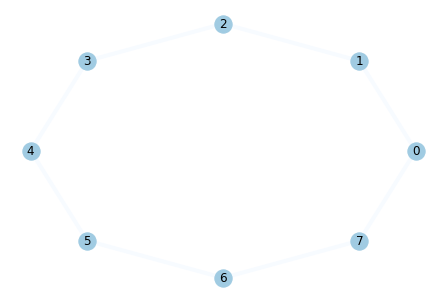

In [25]:
n_nodes = 8
h_disagrees = ring_of_disagrees(n_nodes)
g_disagrees = graph_from_hamiltonian(h_disagrees)
plot_graph(g_disagrees)

In [27]:
p_vals = np.arange(1,5) # p range to consider
output_val = np.zeros((len(p_vals),))

sim = WavefunctionSimulator() # Define the wavefunction simulator

for i in p_vals:
    
    # Initialise angles
    betas = np.random.rand(i)
    gammas_singles = np.zeros((i,)) # Remove this when issue is fixed
    gammas_pairs = np.random.rand(i)
    parameters = (betas, gammas_singles, gammas_pairs)
    
    # Set up (hyper)parameters
    diasagrees_params = StandardParams([h_disagrees,i],parameters)
    
    # Cost function and optimisation
    cost_function = QAOACostFunctionOnWFSim(h_disagrees,
                                            params=diasagrees_params,
                                            sim=sim,
                                            scalar_cost_function=False,
                                            nshots=1,
                                            noisy=False)
    
    res = scipy_optimizer(cost_function, diasagrees_params.raw(), epsilon=1e-3, maxiter=500,method="BFGS")
    
    output_val[i-1] = res.fun - 0.5*len(h_disagrees) # The second term here comes from the identity part 
                                                     # of the MaxCut operator (DOESN'T SEEM POSSIBLE TO INCLUDE)
                                                     # IDENTITY TERMS IN PauliSum WITHOUT OPTIMISER COMPLAINING?)

Since we have 8 qubits, according to Farhi's formula we should find the maximum energy to be $-8*(3/4,5/6,7/8,9/10) = -(6, 6.67, 7, 7.2)$ for $p = (1,2,3,4)$:

In [28]:
output_val

array([-6.        , -6.66666658, -6.99999979, -8.        ])

The lowest energy state corresponds to the situation where neighbouring qubits have opposite orientations:

In [29]:
wf = cost_function.get_wavefunction(res.x)
probs = wf.probabilities()
ind = np.argmax(probs)
opt_state = "{0:08b}".format(ind)
print(opt_state)

01010101
